# ブラインド等化：Satoアルゴリズム (Blind Equalization: Sato Algorithm)

このセクションでは、デジタル通信においてマルチパスなどにより生じる「符号間干渉（ISI: Inter-Symbol Interference）」を、送信元の参照信号（トレーニング系列）なしに除去する**ブラインド等化 (Blind Equalization)** の先駆的手法である「Satoアルゴリズム」を実装します。

このアルゴリズムは、1975年に佐藤洋一氏によって提案されました。
*(出典: Y. Sato, "A Method of Self-Recovering Equalization for Multilevel Amplitude-Modulation Systems," IEEE Trans. Commun., vol. 23, no. 6, pp. 679-682, June 1975.)*


## 1. 信号の生成 (Generation of Source and Received Signals)
まずは、送信側で生成された **Source Symbols (送信シンボル)** が通信路を通り、符号間干渉 (ISI) と観測雑音の影響を受けた **Received Signal (受信信号)** を作成します。この受信信号が等化器への入力となります。

In [1]:
# @title 1. Generation of Source and Received Signals (4-PAM and Multipath Channel) { run: "auto" }
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.titlesize": 18,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})

# --- System Parameters ---
N_samples = 10000    # Number of total samples (extended for stable analysis)
noise_var = 0.005    # Variance of additive white Gaussian noise (AWGN)

np.random.seed(42)

# 1. Generate Source Symbols (s_source) using 4-PAM: {-3, -1, 1, 3}
# These are the original "Ideal" symbols we want to recover.
source_levels = np.array([-3, -1, 1, 3])
s_source = np.random.choice(source_levels, N_samples)

# 2. Define a dispersive multipath channel (causes Inter-Symbol Interference)
# This represents the "Unknown System" that distorts our signal.
h_channel = np.array([0.5, 1.0, -0.3, 0.1, -0.05])

# 3. Generate Received Signal (x_received)
# This is the distorted signal that the receiver actually observes.
x_received = np.convolve(s_source, h_channel, mode='full')[:N_samples]
x_received += np.sqrt(noise_var) * np.random.randn(N_samples)

print(f"Successfully generated {N_samples} samples.")
print(f"Source: 4-PAM {source_levels} | Channel taps: {h_channel}")

Successfully generated 10000 samples.
Source: 4-PAM [-3 -1  1  3] | Channel taps: [ 0.5   1.   -0.3   0.1  -0.05]


## 2. Satoアルゴリズムの理論と実行 (Sato Algorithm Execution)

Satoアルゴリズムは、多値PAM信号の「離散的な振幅構造」を利用するブラインド等化法です。  
等化器（FIRフィルタ）の出力を

$$
y(n) = \mathbf{w}^T(n)\mathbf{x}(n)
$$

とすると、以下の誤差関数 $e(n)$ を用いてタップ係数 $\mathbf{w}(n)$ を更新します。

$$
e(n) = y(n) - \gamma \,\mathrm{sgn}(y(n))
$$

$$
\mathbf{w}(n+1) = \mathbf{w}(n) - \mu\, e(n)\,\mathbf{x}(n)
$$

ここで、

- $\mathrm{sgn}(\cdot)$ は符号関数
- $\mu$ はステップサイズ
- $\gamma$ は送信信号 $s(n)$ の振幅分布に依存する定数

です。

$\gamma$ は一般に

$$
\gamma = \frac{E[|s(n)|^2]}{E[|s(n)|]}
$$

で与えられます。

例えば 4-PAM（$\{-3,-1,1,3\}$ を等確率でとる）の場合、

$$
\gamma = \frac{5}{2} = 2.5
$$

となります。

---

### Satoアルゴリズムの直感的解釈

この更新式は「判定」を直接行っているわけではありません。  
$\mathrm{sgn}(y(n))$ は2値しか返しませんが、$\gamma$ によって出力振幅のスケールが制御され、結果として出力分布が多峰構造（例：4-PAMでは4つのピーク）に引き寄せられます。

つまり Sato は、

- 出力分布を離散的レベルに押し付ける非線形フィードバック
- 勾配降下による確率的適応

を組み合わせたアルゴリズムです。

---

## ブラインド等化の本質的な不定性

ブラインド等化は原理的に以下の不定性を持ちます：

- スケール不定性（gain ambiguity）
- 符号反転不定性
- 遅延不定性

したがって、等化後の出力が理想レベル（例：$\pm 1, \pm 3$）と完全一致するとは限りません。  
適切な正規化を行わない限り、振幅は比例スケーリングされた形になります。

---

## 学習の評価指標：残存ISI (Residual ISI)

誤差 $e(n)$ 自体は入力信号の分散に依存するため、収束評価には適していません。  
そこで、通信路 $\mathbf{h}$ と等化器 $\mathbf{w}(n)$ の合成インパルス応答

$$
\mathbf{g}(n) = \mathbf{h} * \mathbf{w}(n)
$$

を用いて評価します。

理想的な等化が達成されると、

$$
\mathbf{g}(n) \approx \delta(n-n_0)
$$

すなわち、ある遅延 $n_0$ を持つデルタ関数に近似されます。  
これはチャネル歪みが除去され、符号間干渉（ISI）が抑圧された状態を意味します。

残存ISIは、

$$
\mathrm{ISI}(n) =
10 \log_{10}
\left(
\frac{
\sum_k |g_k(n)|^2 - \max_k |g_k(n)|^2
}{
\max_k |g_k(n)|^2
}
\right)
\quad \text{[dB]}
$$

で定義されます。

この値が小さいほど、主タップ以外のエネルギーが小さくなり、合成応答がデルタ関数に近づいていることを示します。

> ⚠️ **注意（Residual ISIについて）**  
> Residual ISI はエネルギー比に基づく指標であり、BERやEVMとは異なります。  
> これは合成インパルス応答の主タップ以外のエネルギー割合を測定する簡易的評価指標です。

In [2]:
# @title 2. Sato Algorithm Execution (Equalization) { run: "auto" }

# @markdown ### 🔽 Algorithm Parameters
mu_sato = 0.002  # @param {type:"slider", min:0.0001, max:0.01, step:0.0001}
n_taps = 15      # @param {type:"slider", min:5, max:31, step:2}

print("Running Sato Algorithm for adaptive equalization...")

def run_sato_equalization(
    x_received: np.ndarray,
    h_channel: np.ndarray,
    source_levels: np.ndarray,
    mu: float = 0.002,
    n_taps: int = 15,
    init: str = "center",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Sato blind equalization for real-valued PAM signals.

    Returns:
        y_equalized     : equalized output signal (length N)
        isi_history_db  : residual ISI history in dB (length N)
        w_equalizer     : final equalizer weights (length n_taps)
        gamma           : Sato gamma computed from source levels
    """
    N = len(x_received)

    # Compute gamma from source levels (e.g., 4-PAM -> 2.5)
    gamma = np.mean(source_levels**2) / np.mean(np.abs(source_levels))

    # Initialize equalizer weights
    w_equalizer = np.zeros(n_taps, dtype=float)
    if init == "center":
        w_equalizer[n_taps // 2] = 1.0
    elif init == "first":
        w_equalizer[0] = 1.0
    else:
        raise ValueError("init must be 'center' or 'first'")

    y_equalized = np.zeros(N, dtype=float)
    isi_history = np.zeros(N, dtype=float)  # linear scale
    isi_history_db = np.zeros(N, dtype=float)

    # Adaptive equalization loop
    for n in range(n_taps, N):
        # Latest n_taps samples, reversed, form the FIR input vector
        x_vec = x_received[n:n - n_taps:-1]

        # 1) Filtering
        y = np.dot(w_equalizer, x_vec)
        y_equalized[n] = y

        # 2) Sato error (distribution shaping)
        e = y - gamma * np.sign(y)

        # 3) Weight update (stochastic gradient)
        w_equalizer -= mu * e * x_vec

        # 4) Residual ISI based on combined impulse response g = h * w
        g_combined = np.convolve(h_channel, w_equalizer)
        g2 = np.abs(g_combined) ** 2
        max_g2 = np.max(g2)
        isi = (np.sum(g2) - max_g2) / (max_g2 + 1e-12)

        isi_history[n] = isi
        isi_history_db[n] = 10.0 * np.log10(isi + 1e-12)

    # Fill initial region for cleaner plotting
    isi_history[:n_taps] = isi_history[n_taps]
    isi_history_db[:n_taps] = isi_history_db[n_taps]

    return y_equalized, isi_history_db, w_equalizer, gamma


# --- Run Sato equalization ---
y_equalized, isi_history_db, w_equalizer, gamma = run_sato_equalization(
    x_received=x_received,
    h_channel=h_channel,
    source_levels=source_levels,
    mu=mu_sato,
    n_taps=n_taps,
    init="center",
)

print(f"Algorithm execution completed. gamma={gamma:.4f}")

Running Sato Algorithm for adaptive equalization...
Algorithm execution completed. gamma=2.5000


## 3. 結果の可視化と信号分布の比較 (Final Visualization)

ブラインド等化の成果を評価するため、以下の2つの視点でグラフを表示します。

### 1. 信号分布の比較（上段）
等化器に入る前の **Received Signal (受信信号)** と、収束後の **Equalized Output (等化出力)** の確率密度関数 (PDF) を比較します。
* **Received Signal (グレー)**: ISIによって本来の4つのシンボルが重なり合い、閾値判定は不可能な状態です。
* **Equalized Output (青)**: ISIが除去された結果、理想的な **Source Symbols** のレベル（赤点線）に鋭いピークが立ち上がります。

### 2. 残存ISIの学習曲線（下段）
アルゴリズムが「符号間干渉をどれだけ削ぎ落としたか」をデシベル単位で示します。
* **実用的な目標値 (Practical Target)**: $-20$ dB のガイドラインを設けています。これは理論値ではなく、この環境下で安定してシンボル判定が可能になる一つの目安です。

> ⚠️ **注意（ブラインド等化の不定性）**  
> ブラインド等化は原理的に「スケール・符号・遅延」の不定性を持ちます。  
> そのため、等化後のピークが理想レベル（例：±1, ±3）と完全に一致しない場合があります。

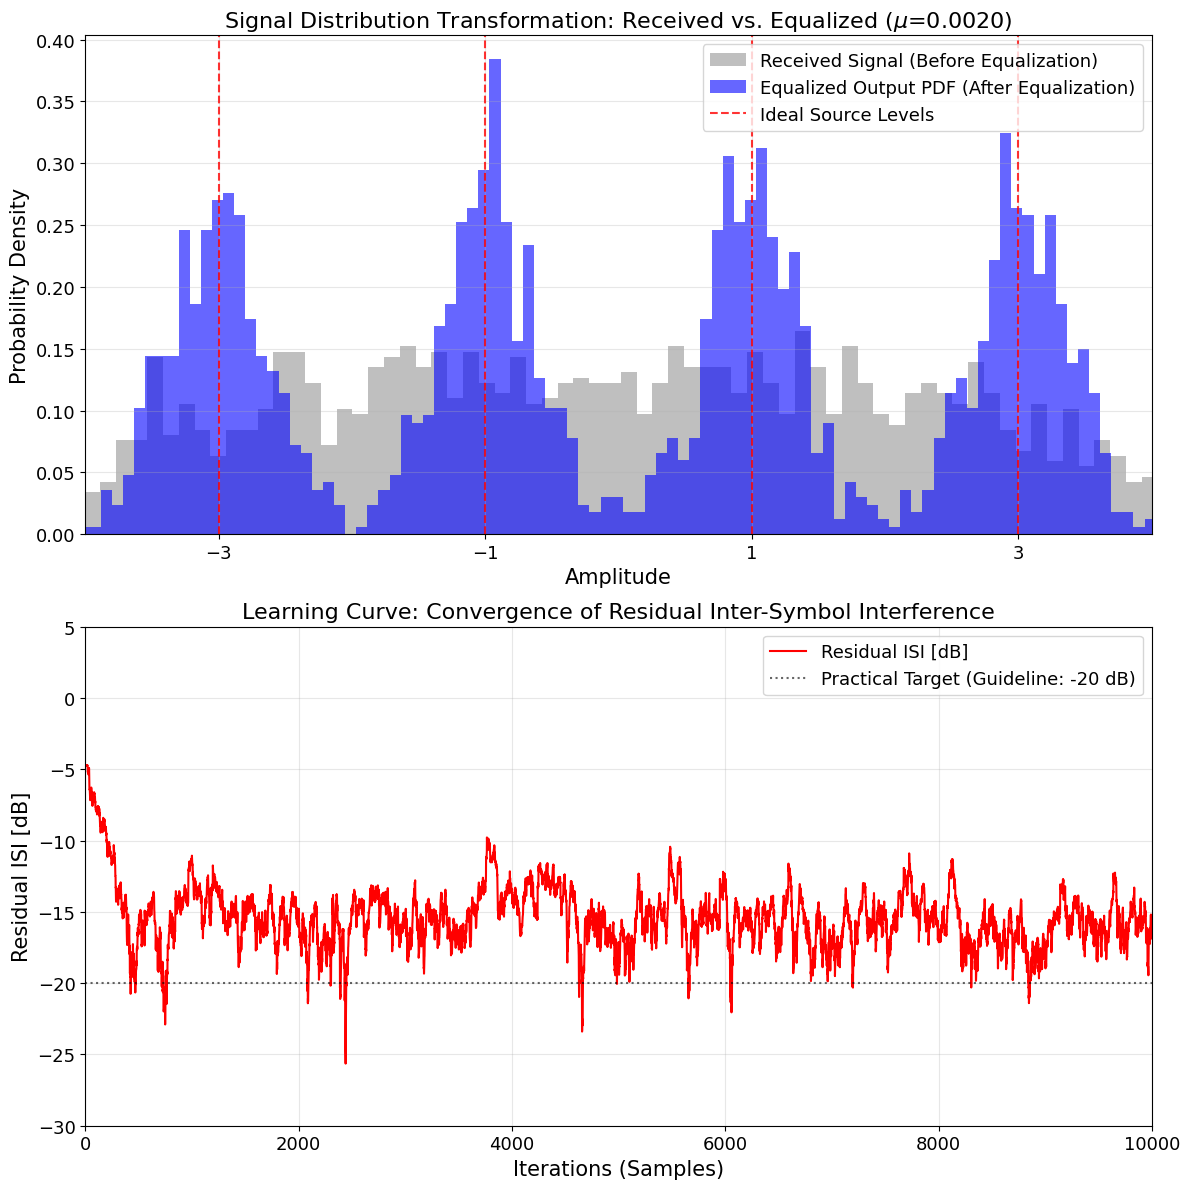

In [3]:
# @title 3. Final Visualization (Distributions + Residual ISI) { run: "auto" }

# --- Plotting Configuration ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# [Upper Plot] PDF Comparison (Before vs After)
analysis_samples = 2000

# Compare early received samples vs late equalized samples (after convergence)
dist_received = x_received[:analysis_samples]
dist_equalized = y_equalized[-analysis_samples:]

# Histogram: Received signal (before equalization)
ax1.hist(
    dist_received,
    bins=100,
    color="gray",
    alpha=0.5,
    density=True,
    label="Received Signal (Before Equalization)",
)

# Histogram: Equalized output (after equalization)
ax1.hist(
    dist_equalized,
    bins=100,
    color="blue",
    alpha=0.6,
    density=True,
    label="Equalized Output PDF (After Equalization)",
)

# Reference lines: ideal source levels (for visualization)
for i, level in enumerate(source_levels):
    ax1.axvline(
        level,
        color="red",
        linestyle="--",
        alpha=0.8,
        label="Ideal Source Levels" if i == 0 else "",
    )

ax1.set_title(rf"Signal Distribution Transformation: Received vs. Equalized ($\mu$={mu_sato:.4f})")
ax1.set_xlabel("Amplitude")
ax1.set_ylabel("Probability Density")
ax1.set_xlim([-6, 6])
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

levels = np.sort(source_levels)
margin = 1.0
ax1.set_xlim([levels[0] - margin, levels[-1] + margin])
ax1.set_xticks(levels)

# [Lower Plot] Learning Curve: Residual ISI (dB)
# NOTE: isi_history_db is returned directly from run_sato_equalization()
ax2.plot(
    np.arange(N_samples),
    isi_history_db,
    color="red",
    linewidth=1.5,
    label="Residual ISI [dB]",
)

# Practical target guideline
ax2.axhline(
    -20,
    color="black",
    linestyle=":",
    alpha=0.6,
    label="Practical Target (Guideline: -20 dB)",
)

ax2.set_title("Learning Curve: Convergence of Residual Inter-Symbol Interference")
ax2.set_xlabel("Iterations (Samples)")
ax2.set_ylabel("Residual ISI [dB]")
ax2.set_xlim([0, N_samples])
ax2.set_ylim([-30, 5])
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 【補足1】Pseudo-Constellation（Delay Embedding）の見方

複素ベースバンド信号では通常「コンスタレーション（I-Q平面）」を描きますが、本デモは実数の4-PAM信号なので、そのままでは2次元の散布図になりません。そこで、出力系列 $y[n]$ を 1サンプル遅延させた $(y[n],\,y[n-1])$ を平面上にプロットし、**2次元の“擬似コンスタレーション（delay embedding）”** として可視化します。

- **横軸**：$y[n]$（現在サンプル）
- **縦軸**：$y[n-1]$（1サンプル前）

もしISIが十分に除去され、$y[n]$ が理想的に $\{-3,-1,1,3\}$ の離散値（近傍）を取るなら、$(y[n],\,y[n-1])$ は 4×4 = 16 通りの組み合わせ付近に点が集まり、散布図は **16個のクラスタ**として現れます。

一方、等化前（受信信号）ではISIやノイズの影響で値が連続的に崩れるため、点群は「にじんだ雲」や「連続的な広がり」として見えやすくなります。

この図は、等化によって
- 分布が「連続的」→「離散的（クラスタ化）」へ変換されること
- ISIが減るとクラスタが締まり、格子状構造が見えてくること

を直感的に確認するためのものです。

> ※ブラインド等化にはスケール・符号・遅延の不定性があるため、クラスタの位置は理想レベルと完全一致しない場合があります。

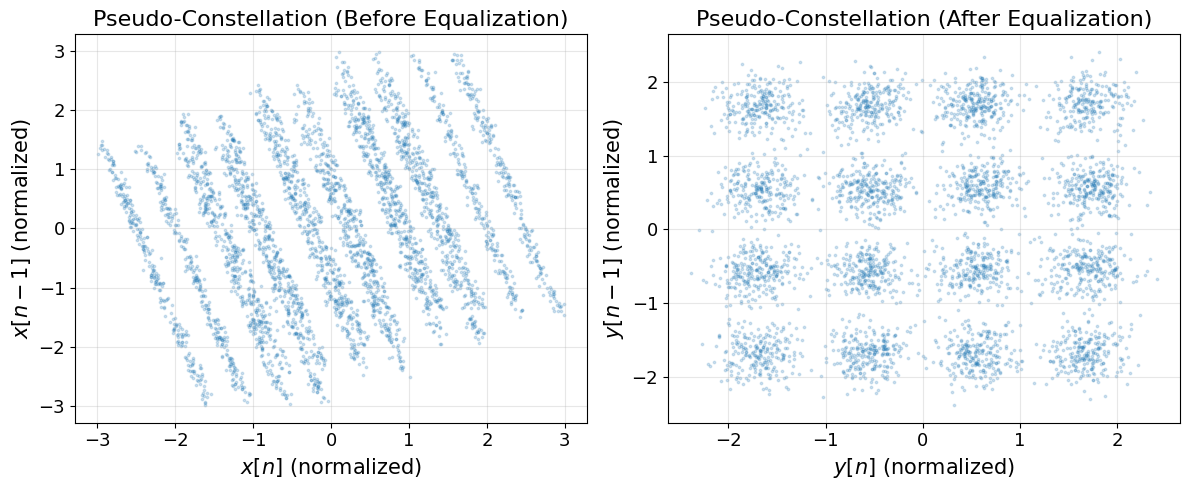

In [4]:
# --- Pseudo-constellation (delay embedding): Before vs After ---

def delay_embedding(z: np.ndarray):
    """Return (z[n], z[n-1]) pairs for scatter plotting."""
    return z[1:], z[:-1]

# Select a segment for visualization (optional: focus on converged region for y)
# For a fair comparison, we show:
# - received: early segment
# - equalized: late segment (after convergence)
plot_samples = 4000  # adjust if needed
z_received = x_received[:plot_samples]
z_equalized = y_equalized[-plot_samples:]

# Optional normalization for visualization (scale ambiguity)
# Normalize by median absolute value so that the spread is comparable.
def robust_normalize(z: np.ndarray):
    s = np.median(np.abs(z))
    return z / (s + 1e-12)

z_received_n = robust_normalize(z_received)
z_equalized_n = robust_normalize(z_equalized)

xr, yr = delay_embedding(z_received_n)
xe, ye = delay_embedding(z_equalized_n)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(xr, yr, s=3, alpha=0.2)
axes[0].set_title("Pseudo-Constellation (Before Equalization)")
axes[0].set_xlabel("$x[n]$ (normalized)")
axes[0].set_ylabel("$x[n-1]$ (normalized)")
axes[0].grid(True, alpha=0.3)

axes[1].scatter(xe, ye, s=3, alpha=0.2)
axes[1].set_title("Pseudo-Constellation (After Equalization)")
axes[1].set_xlabel("$y[n]$ (normalized)")
axes[1].set_ylabel("$y[n-1]$ (normalized)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 図の解説：Pseudo-Constellation（Delay Embedding）

左図は等化前（受信信号）の擬似コンスタレーション、
右図は等化後（Satoアルゴリズム適用後）の擬似コンスタレーションです。

ここでは実数信号 $x[n]$ および $y[n]$ を、
$(z[n],\, z[n-1])$ の2次元平面上に散布図として描いています。

---

#### ■ 左図：Before Equalization（等化前）

左図では点群が斜め方向に伸びた「帯状」の構造になっています。

これは、

- 通信路による畳み込み歪み（ISI）が存在する
- $x[n]$ と $x[n-1]$ の間に強い相関がある

ことを意味します。

本来、4-PAM信号であれば離散的な値しか取りませんが、
チャネル歪みによりサンプルが混ざり、
出力は連続的な値へと崩れています。

その結果、散布図は明確なクラスタを持たず、
「連続的に広がった雲」のような形になります。

---

#### ■ 右図：After Equalization（等化後）

右図では、点群が格子状に分離し、
明確な 4×4 = 16 個のクラスタが形成されています。

これは、

- 合成インパルス応答 $\mathbf{g}(n) = \mathbf{h} * \mathbf{w}(n)$ が
  ほぼデルタ関数に近づき、
- ISI が大きく抑圧された

ことを示しています。

等化が進むと、$y[n]$ は再び
$\{-3,-1,1,3\}$ に対応する離散的な値の近傍を取り、
$(y[n], y[n-1])$ の組み合わせは 16 通りの点に集まります。

この「連続的な帯 → 離散的なクラスタ」への変化が、
ブラインド等化による構造回復を視覚的に示しています。

---

#### ■ 本図は標準設定（デフォルトパラメータ）での結果

本シミュレーションは、デフォルトのステップサイズ $\mu$ やタップ数など、
標準的な設定値における典型的な挙動を示しています。

パラメータ（特に $\mu$ や初期値）を変更すると、

- 収束速度が変化する
- クラスタの広がりが変わる
- 不安定挙動が現れる

場合があります。

したがって、この図は「Satoアルゴリズムの代表的な収束例」であり、
すべての条件で同様の挙動が保証されるわけではありません。

---

#### ■ 重要な点

- ブラインド等化にはスケール・符号・遅延の不定性があります。
- そのためクラスタの位置は理想レベルと完全一致するとは限りません。
- 重要なのは「クラスタが形成されること」そのものです。

この図は、
「相関を持つ連続的な分布が、
構造を持つ離散分布へ変換される」過程を示しています。

### 【補足2】なぜ Sato アルゴリズムは「2値の判定」で「多値信号」を等化できるのか？

Sato アルゴリズムの更新式では、誤差の計算に $\mathrm{sgn}(y(n))$ という「$+1$ か $-1$ か」を返す 2値の符号関数しか用いていません。それにもかかわらず、本シミュレーションのように $\{-3, -1, 1, 3\}$ という 4値（4-PAM）の信号が分離されます。なぜ「2値の情報」だけで「多値信号」が復元できるのでしょうか。

この直感的な疑問の背景には、コスト関数の構造と線形フィルタの制約が深く関係しています。

---

#### 1. 目的関数と定数 $\gamma$ の役割

Sato アルゴリズムの更新式は、以下のコスト関数 $J_S$ を確率的勾配降下法で最小化する操作と等価です。

$$
J_S = E\left[ \frac{1}{2} (|y(n)| - \gamma)^2 \right]
$$

すなわち、等化器は「出力の絶対値 $|y(n)|$ を平均的に $\gamma$ に近づける」ように学習します。

4-PAM（$\{-3, -1, 1, 3\}$ を等確率でとる信号）の場合、

$$
\gamma = \frac{E[|s(n)|^2]}{E[|s(n)|]}
= \frac{(9 + 1 + 1 + 9)/4}{(3 + 1 + 1 + 3)/4}
= \frac{5}{2} = 2.5
$$

となります。

ここで重要なのは、$\gamma = 2.5$ は送信信号のレベルそのものではなく、**統計量から決まるスケール係数**であるという点です。出力を $2.5$ に固定することが目的ではありません。

---

#### 2. 線形フィルタの制約と ISI=0 の安定点

等化器は FIR フィルタであり、出力は

$$
y(n) = \mathbf{w}^T(n)\mathbf{x}(n)
$$

という入力信号の線形結合で与えられます。そのため、出力を任意の定数に強制的に固定することはできません。

Sato アルゴリズムは出力を $2.5$ に張り付かせるのではなく、出力分布が多値構造に近づく方向へ確率的に更新を行います。

Benveniste ら（1980）の解析によれば、この種のコスト関数を線形フィルタの制約下で最小化すると、

> 通信路 $\mathbf{h}$ と等化器 $\mathbf{w}$ の合成インパルス応答  
> $\mathbf{g}(n) = \mathbf{h} * \mathbf{w}(n)$ が、  
> 1つの主タップを除いてほぼ $0$ になる状態

すなわち

$$
\mathbf{g}(n) \approx \delta(n - n_0)
$$

（ISI が消滅した状態）

が安定な局所解となることが示されています。

---

ISI が十分に抑圧されると、出力は元の信号集合 $\{-3,-1,1,3\}$ に対応する多峰分布へと分離されます。このとき $|y(n)|$ は $1$ と $3$ を等確率でとり、結果として

$$
\gamma = 2.5
$$

という統計量と整合する状態に落ち着きます。

重要なのは、アルゴリズムが「2値判定」によって直接多値を復元しているのではなく、

- 非線形な符号関数による粗い方向付け
- 線形システムという構造的制約
- 確率的勾配降下による適応

が組み合わさることで、ISI=0 の状態へ収束していくという点です。

---

#### デモを通じて体感してほしいこと

$\mathrm{sgn}(\cdot)$ は非常に粗い非線形ですが、線形システムという構造制約の下で適応を繰り返すことで、合成インパルス応答はデルタ関数に近づき、多値信号の構造が自然に復元されます。

これは、不完全な情報（送信信号や通信路を知らない状態）から構造のみを手がかりに系を回復していくブラインド等化の本質を示しています。

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>